In [6]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import os
from feature_extraction import extract_features_from_file_list
from config import feature_extraction_params
import random
import collections
import pickle
from find_cars import find_cars
from heatmap import compute_heatmap_from_detections

/home/jameschien/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


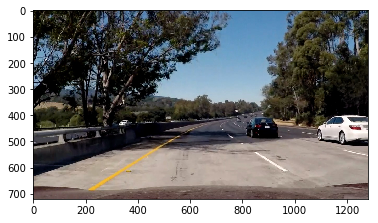

In [2]:
sample_images_dir = 'test_images'
sample_images = [mpimg.imread(p) for p in glob.glob(os.path.join('../', sample_images_dir, '*.jpg'))]
sample_images_features = extract_features_from_file_list(sample_images, feature_extraction_params)
plt.imshow(sample_images[random.randint(0, len(sample_images)-1)])
plt.show()

In [3]:
svc = pickle.load(open('weights/svc_car.pickle', 'rb'))
feature_scaler = pickle.load(open('weights/feature_scaler.pickle', 'rb'))

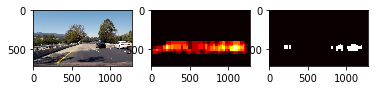

In [7]:
frame = sample_images[0]
ystart = 400
ystop = 600

hot_windows = []

timewindow = 5
hot_windows_history = collections.deque(maxlen=timewindow)

for subsample in np.arange(1, 3, 0.5):
    hot_windows += find_cars(frame, ystart, ystop, subsample,
                             svc, feature_scaler, feature_extraction_params, verbose=False)

keepState = True

if keepState:
    if hot_windows:
        hot_windows_history.append(hot_windows)
        hot_windows = np.concatenate(hot_windows_history)

# compute the heatmap? what's the heatmap means?
# heatmap means level of sliding windows overlay
threshold = (timewindow-1) if keepState else 0
heatmap, heatmap_thresh = compute_heatmap_from_detections(frame, hot_windows, threshold=threshold, verbose=True, save=True)

In [8]:
def draw_boxes(frame, bbox_list, color=(0, 0, 255), thick=6):
    cp_frame = np.copy(frame)
    
    for bbox in bbox_list:
        tl_corner = tuple(bbox[0])
        br_corner = tuple(bbox[1])
        cv2.rectangle(cp_frame, tl_corner, br_corner, color, thick)
        
    return cp_frame

object number: 5


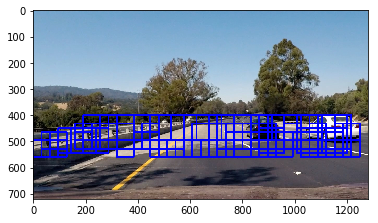

In [9]:
from scipy.ndimage.measurements import label

labeled_frame, num_objects = label(heatmap_thresh)
print("object number: {}".format(num_objects))

# blending
blend_frame = draw_boxes(frame, hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(blend_frame)